# Imaging at large angles

In [1]:
from pylab import *
import numpy as np
from astropy.io import fits
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
import time
%matplotlib notebook

In [2]:
ls /data/craco/ban115/test_data/

ddgrid/                       frb_d0_t3_a1_sninf_lm00/      nant20@
frb_d0_t0_a1_sn10_lm00/       frb_d0_t4_a1_sninf_lm00/      nant3/
frb_d0_t0_a1_sninf_lm00/      frb_d0_t9_a1_sninf_lm00/      nant30/
frb_d0_t0_a1_sninf_lm100200/  frb_d2_t0_a1_sninf_lm00/      nant36/
frb_d0_t0_a2_sninf_lm00/      frb_d2_t4_a1_sn10_lm300400/   old_tranpose/
frb_d0_t1_a1_sninf_lm00/      frb_d2_t4_a1_sninf_lm300400/  transpose_31204/
frb_d0_t2_a1_sninf_lm00/      frb_d3_t7_a1_sninf_lm00/


In [3]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
fits = '/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm100200/frb_d0_t0_a1_sninf_lm100200.fits'
#fits='/data/craco/ban115/test_data/nant3/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
values = craco.search_pipeline.get_parser().parse_args([])
print(values)
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2 --max-nbl 465 ")

Namespace(boxcar_weight='sum', calibration=None, cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_input=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=0, flag_ants=None, flag_chans=None, injection_file=None, input_scale=1.0, max_ndm=1024, nblocks=None, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', phase_center_filterbank=None, print_dm0_stats=False, run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, skip_blocks=0, subtract=True, target_input_rms=512, threshold=10.0, uv=None, verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')
parsing values --ndm 2 --max-nbl 465 


/data/craco/ban115/craft-github/src/craft/uvfits.py:100: UserWarning: Unknown int time in file. returning 1ms
  warnings.warn('Unknown int time in file. returning 1ms')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=515.0 2-3 uvpix=(254, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=515.0 2-3 uvpix=(253, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(253, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=1029.0 4-5 uvpix=(0, 251)
  warnings.warn

Upper registers [(3, 1), (4, 1), (34, 2), (35, 2), (36, 2), (37, 2), (38, 2), (39, 2), (40, 2), (41, 2), (42, 2), (43, 2), (44, 2), (45, 2), (46, 2), (87, 2), (88, 2), (89, 2), (90, 2), (91, 2), (92, 2), (93, 2), (94, 2), (95, 2), (96, 2), (97, 2), (98, 2), (99, 2), (100, 2), (101, 2), (102, 2), (103, 2)]
Lower registers [(1, 3), (1, 4), (2, 4), (3, 4), (3, 5), (3, 6), (4, 6), (4, 7), (2, 8), (4, 8), (2, 9), (3, 9), (4, 9), (5, 9), (3, 10), (5, 10), (7, 10), (3, 11), (5, 11), (6, 11), (7, 11), (7, 12), (8, 12), (8, 13), (9, 13), (7, 14), (8, 14), (9, 14), (8, 15), (8, 16), (9, 16), (2, 17)]


In [4]:
def pointsource(amp, lm, plan, noiseamp=0):
    '''
    Returns simulted visibilities for a point source with given amplitude at given value of lm =(l, m) in radians
    offset from the phase center
        
    :amp: amplitude
    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
    :plan: craco_plan to get all the goodies like UVWs and stuff from
    :noiseamp: add nois with tgiven ampliutude
    :returns: np.array of complex dtype with shape (nbl, nchan)
    '''
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    
    l, m = lm
    dout = np.empty((nbl, nf), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        w = uvw_sec[2]*freqs

        # TMS equation 3.7 - don't include 1/sqrt(1 - l*l - m*m) denomiator term for point sources
        vis = amp*np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        if noiseamp > 0:
            vishape = vis.shape
            noise = noiseamp*(np.random.randn(*vishape) + 1j*np.random.randn(*vishape))
            vis += noise

        dout[ibl, :] = vis

    return dout

In [5]:
lm = (0,0.1)
lmarcsec = np.array((100,200))
lm = np.sin(np.radians(lmarcsec/3600))
lm=(0.01,0.02)
lm = np.sin(np.radians([0.5,0.5]))
vissim = pointsource(1, lm, plan)
print('lm', lm)

lm [0.00872654 0.00872654]


<IPython.core.display.Javascript object>


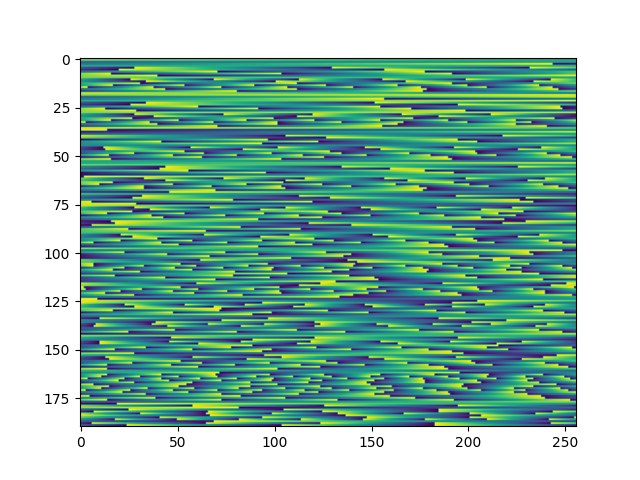

In [6]:
figure()
imshow(np.angle(vissim))

In [7]:
uvws = []
freqs = plan.freqs

for ibl, blid in enumerate(plan.baseline_order):       
    # baselines in seconds
    uvw_sec = np.array(plan.baselines[blid][:3])

    # convert UVW coordinates to wavelegths
    u = uvw_sec[0]*freqs
    v = uvw_sec[1]*freqs
    w = uvw_sec[2]*freqs
    uvws.append((u,v,w))
    
uvws = np.array(uvws)
uvws.shape

(190, 3, 256)

<IPython.core.display.Javascript object>


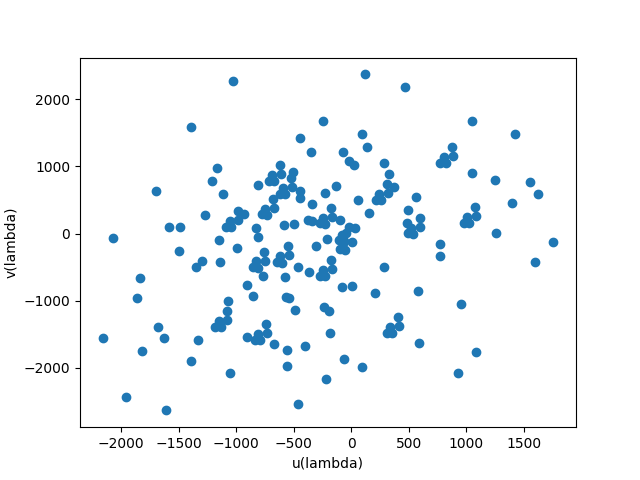

Text(0, 0.5, 'v(lambda)')

In [8]:
figure()
scatter(uvws[:,0,0],uvws[:,1,0])
xlabel('u(lambda)')
ylabel('v(lambda)')


<IPython.core.display.Javascript object>


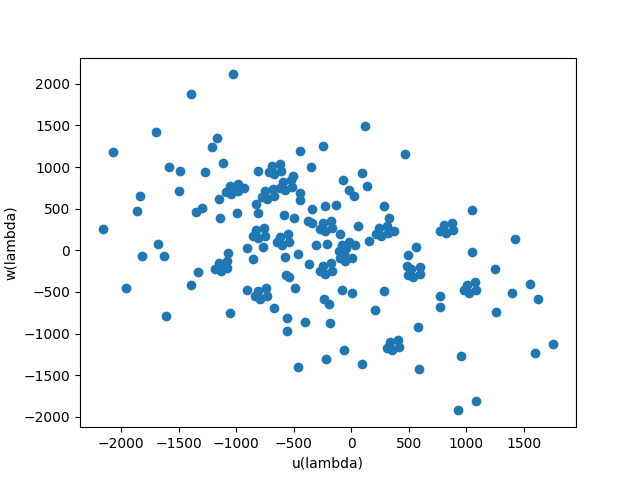

Text(0, 0.5, 'w(lambda)')

In [9]:
figure()
scatter(uvws[:,0,0],uvws[:,2,0])
xlabel('u(lambda)')
ylabel('w(lambda)')

<IPython.core.display.Javascript object>


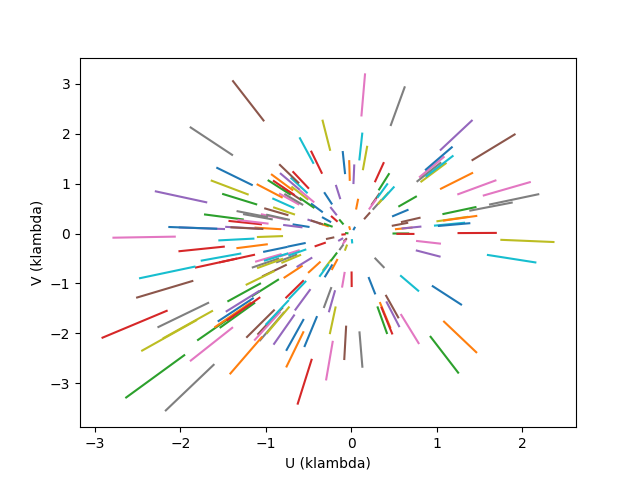

In [10]:
figure()
f.plot_baselines()

In [11]:
blid = d['BASELINE']
blid

NameError: name 'd' is not defined

In [ ]:
u,v,w = d['UU'],d['VV'],d['WW']
freqs = plan.freqs
ulam, vlam, wlam = u*freqs, v*freqs, w*freqs


In [ ]:
vis = d['DATA']

In [ ]:
visc = d['DATA'][0,0,:,0,0] + d['DATA'][0,0,:,0,1]*1j

In [ ]:
idx = np.where(plan.baseline_order == blid)[0][0]

In [ ]:
vissim[idx,:].shape

In [ ]:
vissim.shape

In [ ]:
figure()
plot(np.degrees(np.angle(visc)))
plot(np.degrees(np.angle(np.conj(vissim[idx,:]))),'x')

In [ ]:
figure()
_ = plot(np.angle(vissim).T)

In [12]:
def grid(plan, din, uvcell, npix):
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
        
    g = np.zeros((npix,npix), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        #w = uvw_sec[2]*freqs
        
        #vis = np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        pivot = npix // 2
        upix = np.round(u/uvcell[0]).astype(int)
        vpix = np.round(v/uvcell[1]).astype(int)
        for ichan, (up,vp) in enumerate(zip(upix,vpix)):
            g[pivot+up,pivot+vp] += din[ibl,ichan]
            g[pivot-up,pivot-vp] += np.conj(din[ibl,ichan])
        

        
        
    return g

def doimage(g):
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(g)))
    

lm=[0.00872654 0.00872654]


<IPython.core.display.Javascript object>


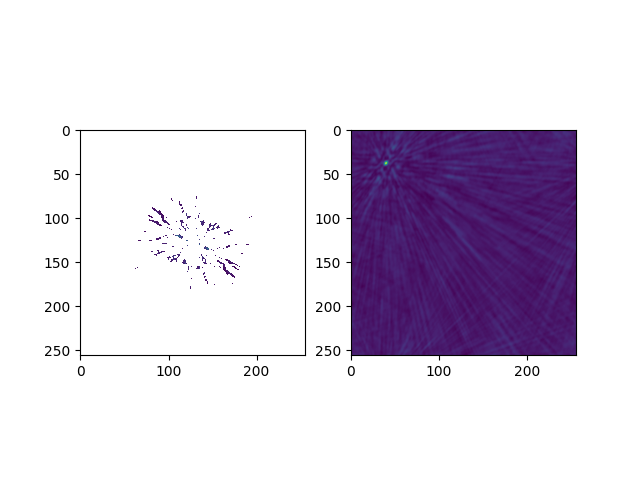

In [13]:
c = 40
uvcell=(c,c)
npix=256
lm = (0,0.1)
lmarcsec = np.array((100,200))
lm = np.sin(np.radians(lmarcsec/3600))
lm = np.sin(np.radians([0.5,0.5]))
print(f'lm={lm}')
#lm=(0.01,0.02)
#lm = (0,0)
#lm = (0,0)
peak = 97280.0
vissim = pointsource(1, lm, plan)

fig,ax = subplots(1,2)
g = grid(plan, vissim, uvcell, npix)/np.prod(vissim.shape)/2 # Scales image to 1 for phase center
img = doimage(g)
gimg = abs(g)
gimg[gimg==0] = np.nan
ax[0].imshow(gimg)
ax[1].imshow(img.real)
        

In [14]:


for c in (2,5,10,15,20,30,40):
    for npix in (256,512,1024,2048,4096):
        uvcell=(c,c)
        try:
            g = grid(plan, vissim, uvcell, npix)
            img = doimage(g)
            print(f'c={c} npix={npix} max={img.real.max()/peak}')
        except:
            print(f'Couldnt grid c={c} npix={npix}')
        

Couldnt grid c=2 npix=256
Couldnt grid c=2 npix=512
Couldnt grid c=2 npix=1024
Couldnt grid c=2 npix=2048
c=2 npix=4096 max=0.9930350020296866
Couldnt grid c=5 npix=256
Couldnt grid c=5 npix=512
Couldnt grid c=5 npix=1024
c=5 npix=2048 max=0.9776824675110262
c=5 npix=4096 max=0.9776824675110262
Couldnt grid c=10 npix=256
Couldnt grid c=10 npix=512
c=10 npix=1024 max=0.9596721272938287
c=10 npix=2048 max=0.9596721272938287
c=10 npix=4096 max=0.9711393067814924
Couldnt grid c=15 npix=256
c=15 npix=512 max=0.8764118865562965
c=15 npix=1024 max=0.935030815733643
c=15 npix=2048 max=0.9374200752637203
c=15 npix=4096 max=0.9444469865979325
Couldnt grid c=20 npix=256
c=20 npix=512 max=0.888003959599933
c=20 npix=1024 max=0.888003959599933
c=20 npix=2048 max=0.8998670204549263
c=20 npix=4096 max=0.9027175464092361
c=30 npix=256 max=0.7346447158058006
c=30 npix=512 max=0.7834777288456419
c=30 npix=1024 max=0.7856925673526576
c=30 npix=2048 max=0.7914925296104448
c=30 npix=4096 max=0.791492529610

In [15]:
sum(abs(vissim))

48640.0

In [16]:
np.prod(vissim.shape)

48640

In [17]:
def degrid(plan, lm, uvcell):
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    l,m = lm
        
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    
    l, m = lm
    dout = np.empty((nbl, nf), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        w = uvw_sec[2]*freqs
        
        #vis = np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        if uvcell is not None:
            u = np.round(u/uvcell[0])*uvcell[0]
            v = np.round(v/uvcell[1])*uvcell[1]
            
        devis = np.exp(-2j*np.pi*(u*l + v*m + 0*w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        dout[ibl,:] = devis
    return dout

vissimdg = degrid(plan,lm,uvcell=None)
print(np.sum(np.conj(vissimdg)*vissim)/np.prod(vissim.shape))

(0.9253801044664884+0.040132653085809j)


<IPython.core.display.Javascript object>


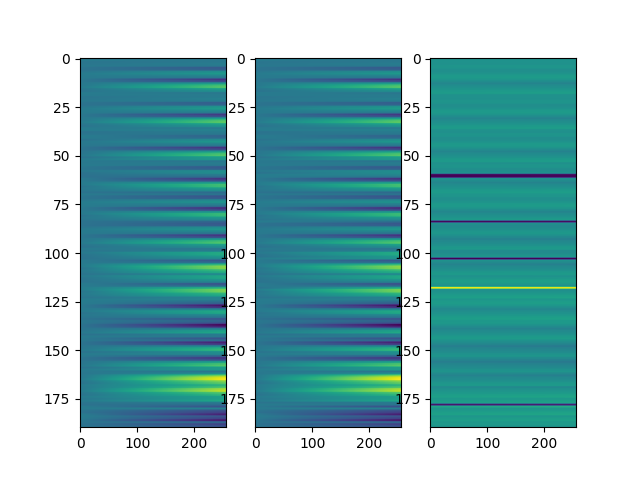

In [19]:
def myang(d):
    return np.degrees(np.unwrap(np.angle(d)))
fig,ax = subplots(1,3)
ax[0].imshow(myang(vissim), aspect='auto')
ax[1].imshow(myang(vissimdg), aspect='auto')
ax[2].imshow(myang(vissim) - myang(vissimdg), aspect='auto')


<IPython.core.display.Javascript object>


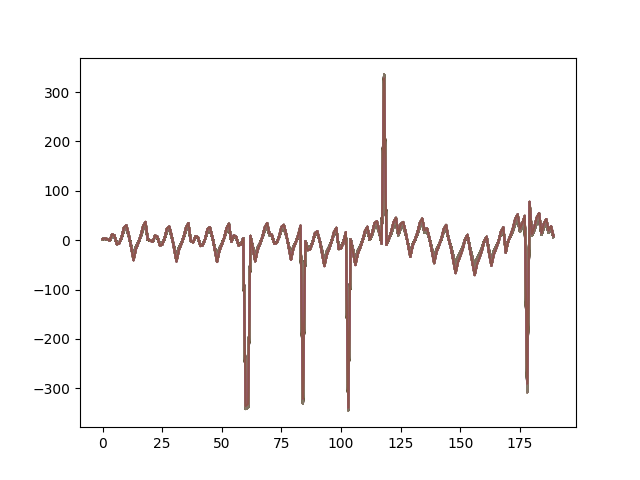

In [21]:
figure()
x = myang(vissim) - myang(vissimdg)
plot(x)